In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
from datetime import datetime
from utils import AdjustPixelsRange
from unet import UNet, ResnetBlock, DownSample, UpSample
from ddpm import DDPM
from ddim import DDIM

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])
dataset = torchvision.datasets.MNIST('../data/mnist', train=True, transform=transform, download=False)
test_dataset = torchvision.datasets.MNIST('../data/mnist', train=False, transform=transform, download=False)

dataset[0][0].min(), dataset[0][0].max()

(tensor(0.), tensor(0.9922))

## KL Auto Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(
            self,
            in_channels=3,
            start_channels=64,
            latent_dim=16,
            num_resnet_blocks=2,
            dropout_prob=0.0,
            gp_norm_groups=16,
            channels_multiplier_arr=[1, 2, 2, 4],
            levels_to_apply_attention=[False, False, False, True]
        ):
        super().__init__()

        self.init_conv = nn.Conv2d(in_channels, start_channels, kernel_size=3, padding=1)
        
        self.down_blocks = nn.ModuleList()
        curr_in_channels = start_channels
        for level, ch_multiplier in enumerate(channels_multiplier_arr):
            out_channels = start_channels * ch_multiplier
            for _ in range(num_resnet_blocks):
                self.down_blocks.append(
                    ResnetBlock(
                        curr_in_channels,
                        out_channels,
                        0,
                        dropout_prob,
                        use_attention=levels_to_apply_attention[level], 
                        gp_norm_groups=gp_norm_groups
                    )
                )
                curr_in_channels = out_channels
            if level != len(channels_multiplier_arr)-1:
                self.down_blocks.append(DownSample(curr_in_channels))
        
        self.final_blocks = nn.ModuleList([
            ResnetBlock(curr_in_channels, curr_in_channels, 0, dropout_prob, use_attention=True, gp_norm_groups=gp_norm_groups),
            ResnetBlock(curr_in_channels, curr_in_channels, 0, dropout_prob, use_attention=False, gp_norm_groups=gp_norm_groups),
            nn.GroupNorm(num_groups=gp_norm_groups, num_channels=curr_in_channels, eps=1e-6),
            nn.SiLU(),
            nn.Conv2d(curr_in_channels, 2*latent_dim, kernel_size=3, padding=1)
        ])
            

    def forward(self, x):
        out = self.init_conv(x)

        for blocks in [self.down_blocks, self.final_blocks]:
            for block in blocks:
                if isinstance(block, ResnetBlock):
                    out = block(out, None)
                elif isinstance(block, (DownSample, nn.GroupNorm, nn.SiLU, nn.Conv2d)):
                    out = block(out)
                else:
                    raise Exception("Unexpected block")
                
        return out

Encoder()(x=torch.randn(16, 3, 128, 128)).shape

torch.Size([16, 32, 16, 16])

In [6]:
class Decoder(nn.Module):
    def __init__(
            self,
            img_channels=3,
            start_channels=64,
            latent_dim=16,
            num_resnet_blocks=2,
            dropout_prob=0.0,
            gp_norm_groups=16,
            channels_multiplier_arr=[1, 2, 2, 4],
            levels_to_apply_attention=[False, False, False, True]
        ):
        super().__init__()

        curr_in_channels = start_channels*channels_multiplier_arr[-1]

        self.init_blocks = nn.ModuleList([
            nn.Conv2d(latent_dim, curr_in_channels, kernel_size=3, padding=1),
            ResnetBlock(curr_in_channels, curr_in_channels, 0, dropout_prob, use_attention=True, gp_norm_groups=gp_norm_groups),
            ResnetBlock(curr_in_channels, curr_in_channels, 0, dropout_prob, use_attention=False, gp_norm_groups=gp_norm_groups),
        ])

        self.up_blocks = nn.ModuleList()
        for level in reversed(range(len(channels_multiplier_arr))):
            out_channels = start_channels * channels_multiplier_arr[level]
            for _ in range(num_resnet_blocks):
                self.up_blocks.append(
                    ResnetBlock(
                        curr_in_channels,
                        out_channels,
                        0,
                        dropout_prob,
                        use_attention=levels_to_apply_attention[level], 
                        gp_norm_groups=gp_norm_groups
                    )
                )
                curr_in_channels = out_channels
            if level != 0:
                self.up_blocks.append(UpSample(curr_in_channels))
        
        self.final_blocks = nn.ModuleList([
            nn.GroupNorm(num_groups=gp_norm_groups, num_channels=curr_in_channels, eps=1e-6),
            nn.SiLU(),
            nn.Conv2d(curr_in_channels, img_channels, kernel_size=3, padding=1)
        ])

    
    def forward(self, x):
        out = x
        for blocks in [self.init_blocks, self.up_blocks, self.final_blocks]:
            for block in blocks:
                if isinstance(block, ResnetBlock):
                    out = block(out, None)
                elif isinstance(block, (UpSample, nn.GroupNorm, nn.SiLU, nn.Conv2d)):
                    out = block(out)
                else:
                    raise Exception(f"Unexpected block")
                
        return out

Decoder()(x=torch.randn(16, 16, 16, 16)).shape

torch.Size([16, 3, 128, 128])

In [7]:
class DiagonalGaussianDistribution(object):
    def __init__(self, parameters):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)

    def sample(self):
        return self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)

    def kl(self, other=None):
        if other is None:
            return 0.5 * torch.sum(torch.pow(self.mean, 2)
                                    + self.var - 1.0 - self.logvar,
                                    dim=[1, 2, 3])
        else:
            return 0.5 * torch.sum(
                torch.pow(self.mean - other.mean, 2) / other.var
                + self.var / other.var - 1.0 - self.logvar + other.logvar,
                dim=[1, 2, 3])

In [8]:
from torch.distributions.normal import Normal

class VariationAutoEncoder(nn.Module):
    def __init__(self, img_channels, latent_dim, start_channels, channels_multiplier_arr, levels_to_apply_attention):
        super().__init__()

        self.encoder = Encoder(in_channels=img_channels, latent_dim=latent_dim, start_channels=start_channels, channels_multiplier_arr=channels_multiplier_arr, levels_to_apply_attention=levels_to_apply_attention)
        self.decoder = Decoder(img_channels=img_channels, latent_dim=latent_dim, start_channels=start_channels, channels_multiplier_arr=channels_multiplier_arr, levels_to_apply_attention=levels_to_apply_attention)

    def forward(self, x):
        # mu, sigma = torch.chunk(self.encoder(x), chunks=2, dim=1)
        # sigma = sigma.exp()
        # dist = Normal(mu, sigma)
        # z = dist.rsample()
        dist = DiagonalGaussianDistribution(self.encoder(x))
        z = dist.sample()
        decoded = self.decoder(z)
        return dist, decoded

dist, decoded = VariationAutoEncoder(img_channels=1, latent_dim=16, start_channels=16, channels_multiplier_arr=[1, 2, 4], levels_to_apply_attention=[False, False, True])(torch.randn(64, 1, 32, 32))
decoded.shape, dist.mean.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64, 16, 8, 8]))

In [9]:
reconstruction_loss = lambda x, y: (x - y).square().sum(dim=[1, 2, 3]).sum()
kl_divergence_loss = lambda dist: dist.kl().sum()

In [10]:
def plot_reconstruction(original_imgs, reconstructed_imgs, nrow=8):
    _, axs = plt.subplots(1, 2, figsize=(8, 4))

    title_arr = ["Original", "Reconstructed"]
    
    for idx, imgs in enumerate([original_imgs, reconstructed_imgs]):
        img = torchvision.utils.make_grid(imgs, nrow=nrow)
        img = img.permute(1, 2, 0).clip(0, 1).numpy()
        axs[idx].set_title(title_arr[idx])
        axs[idx].imshow(img)
    
    plt.show()

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

vae = VariationAutoEncoder(img_channels=1, latent_dim=16, start_channels=32, channels_multiplier_arr=[1, 2, 3], levels_to_apply_attention=[False, False, True]).to(device)

opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

print("Numer of parameters:", sum(p.numel() for p in vae.parameters()))

Numer of parameters: 2134113


[2023-12-11 14:32:03] [Epoch 19] Train Loss: 1738.92763 - Train Reconstruction Loss: 858.20649 - KL Loss: 880.72115


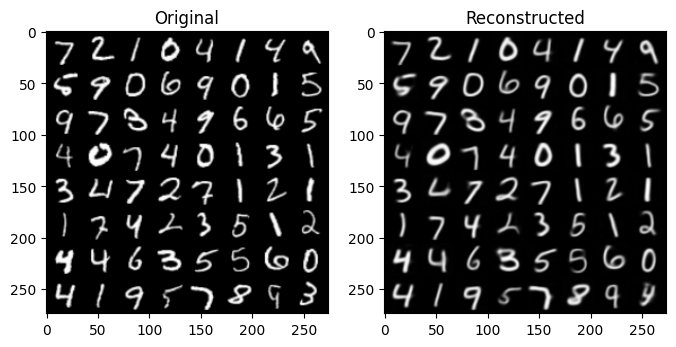

In [48]:
fixed_images = torch.stack([test_dataset[i][0] for i in range(64)], dim=0)

train_loss_arr, train_recon_loss_arr, train_kl_loss_arr = [], [], []

vae.train()
for epoch in range(20):
    train_loss, train_recon_loss, train_kl_loss = 0., 0., 0.
    for idx, (images, _) in enumerate(dataloader):
        images = images.to(device)

        dist, decoded = vae(images)

        recon_loss = reconstruction_loss(decoded, images)
        kl_loss = kl_divergence_loss(dist)
        loss = recon_loss + kl_loss

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() * images.shape[0]
        train_recon_loss += recon_loss.item() * images.shape[0]
        train_kl_loss += kl_loss.item() * images.shape[0]

    train_loss /= len(dataloader.dataset)
    train_recon_loss /= len(dataloader.dataset)
    train_kl_loss /= len(dataloader.dataset)
    train_loss_arr.append(train_loss)
    train_recon_loss_arr.append(train_recon_loss)
    train_kl_loss_arr.append(train_kl_loss)
    
    clear_output()
    
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] [Epoch {epoch:2d}] Train Loss: {train_loss:.5f} - Train Reconstruction Loss: {train_recon_loss:.5f} - KL Loss: {train_kl_loss:.5f}")
    
    plot_reconstruction(fixed_images, vae(fixed_images.to(device))[1].detach().cpu())

    torch.save(vae.state_dict(), "vae.pth")

## Diffusion process in the latent space

In [13]:
vae.load_state_dict(torch.load("vae.pth"))
vae.eval();

In [14]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

ddpm = DDPM(device=device)

model = UNet(
    img_channels=16,
    start_channels=64,
    channels_multiplier_arr=[1, 2, 2],
    levels_to_apply_attention=[False, False, True],
    dropout_prob=0.1,
    num_resnet_blocks=2,
    max_time=1000
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=2e-4)

In [15]:
print("Numer of parameters:", sum(p.numel() for p in model.parameters()))

Numer of parameters: 6551184


In [19]:
train_loss_arr = []

model.train()
vae.eval()

for epoch in range(100):
    train_loss = 0.
    for idx, (images, _) in enumerate(dataloader):
        images = torch.chunk(vae.encoder(images.to(device)), chunks=2, dim=1)[0].detach()

        t = torch.randint(0, ddpm.T, (images.shape[0]//2 + 1, )).to(device)
        t = torch.cat([t, ddpm.T - t - 1], dim=0)[:images.shape[0]]

        noisy_images, noise = ddpm.calculate_xt_from_x0(x_0=images, t=t)

        predicted_noise = model(noisy_images, t)

        loss = (noise - predicted_noise).square().sum(dim=(1, 2, 3)).mean(dim=0)

        opt.zero_grad()
        loss.backward()
        try:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        except Exception:
            pass
        opt.step()

        train_loss += loss.item() * images.shape[0]

    train_loss /= len(dataloader.dataset)
    train_loss_arr.append(train_loss)
    
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] [Epoch {epoch:2d}] Train Loss: {train_loss:.8f}")
    
    torch.save(model.state_dict(), "mnist_unet.pth")

[2023-12-11 18:37:15] [Epoch  0] Train Loss: 235.67080074
[2023-12-11 18:37:49] [Epoch  1] Train Loss: 49.25387891
[2023-12-11 18:38:18] [Epoch  2] Train Loss: 24.57709090
[2023-12-11 18:38:49] [Epoch  3] Train Loss: 17.06089645
[2023-12-11 18:39:20] [Epoch  4] Train Loss: 13.50895733
[2023-12-11 18:39:50] [Epoch  5] Train Loss: 11.42667171
[2023-12-11 18:40:22] [Epoch  6] Train Loss: 10.09225877
[2023-12-11 18:40:52] [Epoch  7] Train Loss: 9.05136735
[2023-12-11 18:41:24] [Epoch  8] Train Loss: 8.47450744
[2023-12-11 18:41:55] [Epoch  9] Train Loss: 7.84524412
[2023-12-11 18:42:26] [Epoch 10] Train Loss: 7.40938741
[2023-12-11 18:42:58] [Epoch 11] Train Loss: 7.17111619
[2023-12-11 18:43:29] [Epoch 12] Train Loss: 6.78221633
[2023-12-11 18:44:00] [Epoch 13] Train Loss: 6.66422778
[2023-12-11 18:44:32] [Epoch 14] Train Loss: 6.44931345
[2023-12-11 18:45:03] [Epoch 15] Train Loss: 6.24927772
[2023-12-11 18:45:36] [Epoch 16] Train Loss: 6.05158916
[2023-12-11 18:46:07] [Epoch 17] Train L

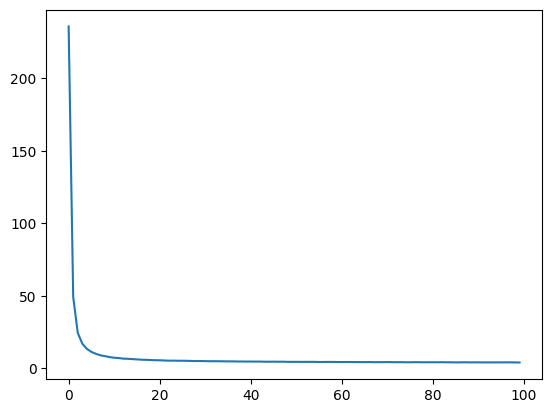

In [20]:
plt.plot(train_loss_arr);

## Evaluation

In [21]:
model.load_state_dict(torch.load("mnist_unet.pth"))
model.eval();

In [22]:
ddim = DDIM(device='cuda')

In [26]:
noise = torch.randn(64, 16, 8, 8).to(device)
generated_encoded_images_batch = ddim.sample_using_uniform_skip(
    x=noise,
    model=model,
    num_steps=100,
    eta=0
)
generated_images = vae.decoder(generated_encoded_images_batch)

In [27]:
vae.encoder(torch.stack([dataset[i][0] for i in range(64)], dim=0).to(device)).max()

tensor(2.5167, device='cuda:0', grad_fn=<MaxBackward1>)

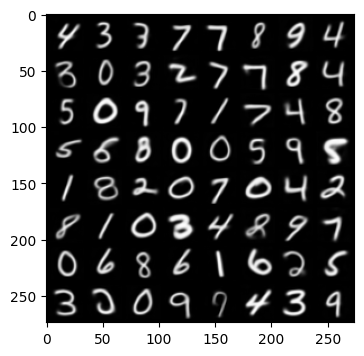

In [28]:
img = torchvision.utils.make_grid(generated_images.detach().cpu(), nrow=8)
img = img.permute(1, 2, 0).clip(0, 1).numpy()

plt.figure(figsize=(4, 4))
plt.imshow(img);